Models were developed to predict pesticide residue levels in the supply chains of maize. The model input included a combination of categorical and numerical variables. Contamination level was used as model output, indicating whether the pesticide residue levels exceeded the limit of quantification as a binary variable. Separate models were constructed for each supply chain, utilizing monitoring data sourced from different repositories. The maize supply chain model utilized data from KAP. As a data preprocessing step, the categorical variables were encoded using one-hot encoding. This is a step to translate the categorical variables into a numerical encoding, which is needed because many machine learning algorithms can't handle categorical input.  

Several machine learning algorithms were implemented to make pesticide residual predictions, namely Random Forest, XGBoost, CatBoost and Support Vector Machine. These models were selected for their historic success in classification problems with structured data. The dataset was randomly split into 80% for the training set and 20% for the test set to train and evaluate the models' performance, respectively. External validation using a different year than present in the training data to show the model's generalizability was not yet performed. In future steps, external validation will be applied for the final model performance evaluation. During training, the algorithms were trained using a class weighted approach where data from the minority class was weighed more than data from the majority class when there was a big class imbalance (maize and lentils). This technique ensures that the algorithms don't develop a bias for the majority class. The model performance is measured using the number of true negatives, false negatives, true positives, false positives and the overall accuracy of the model. The accuracy of the model is calculated by summing the number of true negatives and true positives and dividing it by the total number of predictions.

KAP data the monitoring records for maize were not evenly distributed from 2010 to 2021. The majority of the monitoring records have been collected from 2010 to 2012, and 2013, 2014, 2016 and 2017 are missing from our dataset because of a lack of positive records in those years. Most monitoring records of maize originate from Italy, The Netherlands, and Argentina. Furthermore, around 65 samples stem from an unknown origin.
result from the machine learning models on the test set  using a confusion matrix, which was produced by the XGBoost algorithm. Out of 41 measurements below the LOQ, 31 measurements were classified as true negatives and 10 measurements were classified as false positives. A total of 11 measurements had a value above the LOQ, of which 8 were classified as true positives and 3 were classified as false negatives. This results in an overall accuracy of 75%. 

Note here the no externial valiadation performed due to the limitation of data, model will be updated when more data available.  

XGBoost Classifier:
Test set: [[31 10]
 [ 3  8]] 0.75
Training set: [[141  18]
 [  1  46]] 0.9077669902912622


C:\ProgramData\Anaconda3\Lib\site-packages\pandas\core\internals\blocks.py:2323: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


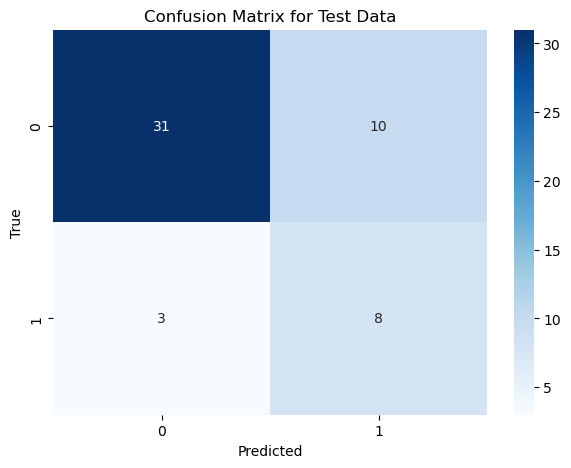

<Figure size 640x480 with 0 Axes>

Using XGBoost classifier:
Test set: [[31 10]
 [ 3  8]] 0.75
Training set: [[141  18]
 [  1  46]] 0.9077669902912622
----------------------------------------
Using CatBoost classifier:
Test set: [[31 10]
 [ 3  8]] 0.75
Training set: [[141  18]
 [  1  46]] 0.9077669902912622
----------------------------------------
Using Random Forest classifier:
Test set: [[33  8]
 [ 3  8]] 0.7884615384615384
Training set: [[143  16]
 [  2  45]] 0.912621359223301
----------------------------------------
Using SVM classifier:
Test set: [[16 25]
 [ 7  4]] 0.38461538461538464
Training set: [[70 89]
 [16 31]] 0.49029126213592233
----------------------------------------
Using Logistic Regression classifier:
Test set: [[ 0 41]
 [ 0 11]] 0.21153846153846154
Training set: [[ 11 148]
 [  3  44]] 0.2669902912621359
----------------------------------------
Using LightGBM classifier:
[LightGBM] [Info] Number of positive: 47, number of negative: 159
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overh

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight  
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Load processed data
Xy44 = pd.read_csv('maize for modelling.csv')

# Split data into training and testing sets

X = Xy44[Xy44['year'] < 2021].iloc[:, 5:-1]
y = Xy44[Xy44['year'] < 2021].iloc[:, -1]

X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Select categorical attributes for encoding
cat_attribs = X.select_dtypes(include=['object']).columns.tolist()

# Create a full pipeline for data preprocessing
full_pipeline = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore'), cat_attribs)], remainder='passthrough')

# Fit the pipeline on training data and transform both training and test data
encoder = full_pipeline.fit(X_train_raw)
X_train = encoder.transform(X_train_raw)
X_test = encoder.transform(X_test_raw)

# Compute class weights
classes_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)

# Train and evaluate XGBoost classifier
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train, sample_weight=classes_weights)

y_pred = xgb_clf.predict(X_test)
y_pred_train = xgb_clf.predict(X_train)


print("XGBoost Classifier:")
print("Test set:", confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred))
print("Training set:", confusion_matrix(y_train, y_pred_train), accuracy_score(y_train, y_pred_train))


# Save test results to a CSV file
results_test_df = pd.concat([pd.concat([X_test_raw, y_test], axis=1).reset_index(drop=True), pd.DataFrame(y_pred, columns=["predict"])], axis=1)
results_test_df.to_csv('results_test_maize.csv', index=False)

# Plot confusion matrices
cm1 = confusion_matrix(y_test, y_pred)


# Create a figure to hold the heatmap
fig, ax = plt.subplots(figsize=(7, 5))

# Plot the confusion matrix
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix for Test Data')

# Display the plot
plt.show()


plt.tight_layout()
plt.show()

# Placeholder for NaN values
placeholder_value = -999
X_train = np.where(np.isnan(X_train), placeholder_value, X_train)
X_test = np.where(np.isnan(X_test), placeholder_value, X_test)
# X2021 = np.where(np.isnan(X2021), placeholder_value, X2021)

# Initialize and train various classifiers
classifiers = {
    'XGBoost': XGBClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Logistic Regression': LogisticRegression(),   
    'LightGBM': LGBMClassifier(),
}

# Train and evaluate each classifier
for name, clf in classifiers.items():
    print(f"Using {name} classifier:")
    
    clf.fit(X_train, y_train, sample_weight=classes_weights)
    
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)
#     y2021_pred = clf.predict(X2021)
    
    print("Test set:", confusion_matrix(y_test, y_pred), accuracy_score(y_test, y_pred))
    print("Training set:", confusion_matrix(y_train, y_pred_train), accuracy_score(y_train, y_pred_train))
#     print("2021 set:", confusion_matrix(y2021, y2021_pred), accuracy_score(y2021, y2021_pred))
    print('-' * 40)
